In [288]:
import itertools
import os.path as op
import warnings
from glob import glob
from time import time

import numpy as np

np.set_printoptions(precision=2, suppress=True)
import pandas as pd

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.stats as stats
import seaborn as sns

co = {
    "red": "#E3120B",
    "blue": "#006BA2",
    "cyan": "#3EBCD2",
    "green": "#379A8B",
    "yellow": "#EBB434",
    "purple": "#9A607F",
    "gray": "#B7C6CF",
    "lgray": "#E9EDF0",
    "dgray": "#758D99",
}

%matplotlib inline

# Project parameters

In [354]:
# Load ROIs.
box_dir = "/Users/dschonhaut/Box"
data_dir = op.join(box_dir, "projects", "ideas", "data")
figs_dir = op.join(box_dir, "projects", "ideas", "figs")
pet_dir = op.join(data_dir, "all_niftis")
roi_dir = op.join(data_dir, "ROIs_rPOP")
missingvox_dir = op.join(data_dir, "missing_voxels")
ref_regionf = op.join(roi_dir, "wc_voi_bin.nii")
cl_roif = op.join(roi_dir, "ctx_voi_bin.nii")
halo_roif = op.join(roi_dir, "halo_roi.nii")
wb_roif = op.join(roi_dir, "rc1-2-thr25-mask.nii")

# Definitions

In [221]:
def toggle_gzip(infile):
    """Toggle file string gzipping."""
    if infile.endswith(".gz"):
        return infile[:-3]
    else:
        return infile + ".gz"


def load_nii(
    infile,
    dtype=np.float32,
    flatten=False,
    conv_nan=0,
    binarize=False,
    int_rounding="nearest",
):
    """Load a NIfTI file and return the NIfTI image and data array.

    Parameters
    ----------
    infile : str
        The nifti file to load.
    dtype : data-type
        Determines the data type of the data array returned.
    flatten : bool
        If true, `dat` is returned as a flattened copy of the
        `img`.dataobj array. Otherwise `dat`.shape == `img`.shape.
    conv_nan : bool, number, or NoneType object
        Convert NaNs to `conv_nan`. No conversion is applied if
        `conv_nan` is np.nan, None, or False.
    binarize : bool
        If true, `dat` values > 0 become 1 and all other values are 0.
        `dat` type is recast to np.uint8.
    int_rounding : str
        Determines how the data array is recast if `binarize` is false
        and `dtype` is an integer.
        `nearest` : round to the nearest integer per np.rint
        `floor` : round down
        `ceil` : round up

    Returns
    -------
    img : Nifti1Image
    dat : ndarray or ndarray subclass
        dat.dtype is np.float32 by default, or np.uint8 if `binarize` is
        true.
    """
    # Get the right file extension.
    if not op.exists(infile):
        infile = toggle_gzip(infile)

    # Load the NIfTI image and data array.
    img = nib.load(infile)
    dat = np.asanyarray(img.dataobj)

    # Flatten the data array.
    if flatten:
        dat = dat.ravel()

    # Convert NaNs.
    if not np.any((conv_nan is None, conv_nan is False, conv_nan is np.nan)):
        dat[np.isnan(dat)] = conv_nan

    # Binarize the data array.
    if binarize or (dtype is bool):
        idx = dat > 0
        dat[idx] = 1
        dat[~idx] = 0
        if dtype is bool:
            dat = dat.astype(bool)
        else:
            dat = dat.astype(np.uint8)

    # Recast to an integer data type.
    elif "int" in str(dtype):
        if int_rounding == "nearest":
            dat = np.rint(dat)
        elif int_rounding == "floor":
            dat = np.floor(dat)
        elif int_rounding == "ceil":
            dat = np.ceil(dat)
        else:
            raise ValueError("int_rounding='{}' not valid".format(int_rounding))
        dat = dat.astype(dtype)

    # Recast to float.
    else:
        dat = dat.astype(dtype)

    # Return the NIfTI image and data array.
    return img, dat


def save_nii(img, dat, filename, overwrite=False, verbose=True):
    """Save a new NIfTI image to disc."""
    if overwrite or not op.exists(filename):
        newimg = nib.Nifti1Image(dat, affine=img.affine, header=img.header)
        newimg.to_filename(filename)
        if verbose:
            print("Saved {}".format(filename))
    return None


def nii2arr(infile, conv_nan=True, dtype=None):
    """Load nifti file as a numpy array."""
    if not op.exists(infile):
        infile = toggle_gzip(infile)

    arr = np.asanyarray(nib.load(infile).dataobj, dtype=dtype)

    if conv_nan:
        arr[np.isnan(arr)] = 0

    if dtype:
        arr = arr.astype(dtype)

    return arr


def create_suvr(pet, ref_region, outfile=None, overwrite=False, verbose=False):
    """Return PET SUVR data array and optionally the SUVR image to disc."""
    # Load the PET image.
    if isinstance(pet, str):
        pet_img, pet_dat = load_nii(pet)
    elif isinstance(pet, (nib.Nifti1Image, nib.Nifti2Image)):
        pet_img, pet_dat = load_nii(pet.get_filename())
    else:
        pet_dat = pet

    # Load the reference region.
    if isinstance(ref_region, str):
        rr_img, rr_dat = load_nii(ref_region, binarize=True)
    elif isinstance(ref_region, (nib.Nifti1Image, nib.Nifti2Image)):
        rr_img, rr_dat = load_nii(ref_region.get_filename(), binarize=True)
    else:
        rr_dat = ref_region

    # Format the reference region to match the PET image.
    if isinstance(rr_dat, np.ndarray):
        if (pet_dat.ndim == 1) and (rr_dat.ndim > 1):
            rr_dat = rr_dat.ravel()
        elif (pet_dat.ndim > 1) and (rr_dat.ndim == 1):
            pet_dat = pet_dat.ravel()
        assert pet_dat.shape == rr_dat.shape
        rr_idx = np.where(rr_dat)
    else:
        rr_idx = rr_dat

    # Make the SUVR.
    rr_mean = np.mean(pet_dat[rr_idx])
    if verbose:
        print("Ref. region mean = {:.2f}".format(rr_mean))
    suvr_dat = pet_dat / rr_mean
    if suvr_dat.ndim < pet_dat.ndim:
        suvr_dat = suvr_dat.reshape(suvr_dat.shape)

    # Save the SUVR image.
    if outfile and np.any((overwrite, not op.exists(outfile))):
        if "pet_img" not in locals():
            if "rr_img" not in locals():
                msg = (
                    "\nCannot save SUVR due to missing header info."
                    "\nMust import `pet` or `ref_region` as a filename "
                    "or Nifti{1,2}Image."
                )
                warnings.warn(msg)
            else:
                assert pet_dat.shape == rr_img.shape
                affine = rr_img.affine
                header = rr_img.header
        else:
            affine = pet_img.affine
            header = pet_img.header
        suvr_img = nib.Nifti1Image(suvr_dat, affine, header)
        suvr_img.to_filename(outfile)
        if verbose:
            print("Saved {}".format(outfile))

    return suvr_dat


def vox_mean(pet, roi_idx):
    """Return the mean pet value within selected voxels."""
    return np.mean(pet[roi_idx])


def get_halo_thresh(pet, halo_idx, thresh=2):
    """Calculate the halo threshold."""
    halo_thresh = np.mean(pet[halo_idx]) + (np.std(pet[halo_idx]) * thresh)
    return halo_thresh


def get_missing_roi(pet, affine, header, outfile, overwrite=False, verbose=False):
    """Save the missing voxels nifti image."""
    # Save a nifti image for the missing voxels.
    missing_roi = np.zeros(pet.shape, dtype=np.byte)

    # Ref. region missing = 1
    idx = np.all((ref_region > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 1

    # Cortical amyloid region missing = 2
    idx = np.all((cl_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 2

    # Remaining brain missing = 3
    idx = np.all((wb_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
    missing_roi[idx] = 3

    # Save the file as a new image.
    if overwrite or not op.exists(outfile):
        newimg = nib.Nifti1Image(
            missing_roi, pet_img.affine, pet_img.header, dtype=missing_roi.dtype
        )
        newimg.to_filename(outfile)
        if verbose:
            print("Saved {}".format(outfile))

    return missing_roi

# Make halo ROI

In [4]:
# Create the halo ROI.
# passband = [0.01, 0.1]
passband = [0.01, 0.15]
zcutoff = 4
roi_dir = "/Users/dschonhaut/Box/projects/ideas/halo_roi"
infile = op.join(roi_dir, "s12rc1-5_mask_fixed.nii")
outfile = op.join(roi_dir, "halo_roi_thr01-15.nii")
overwrite = True
# ---------------------

# Load the image.
img = nib.load(infile)
dat = np.asanyarray(img.dataobj)

# Initialize the mask.
mask = np.zeros(img.shape, dtype=np.byte)

# Mask voxels within the smoothing passband.
idx = np.all([dat >= passband[0], dat < passband[1]], axis=0)
mask[idx] = True

# Remove mask voxels below the cutoff axial slice.
mask[:, :, :zcutoff] = False

# Save the file as a new image.
if overwrite or not op.exists(outfile):
    newimg = nib.Nifti1Image(mask, img.affine, img.header, dtype=mask.dtype)
    # newimg.to_filename(outfile)
    # print("Saved {}".format(outfile))

# Save L/R ROIs

In [15]:
roi_files = [ref_regionf, cl_roif, wb_roif, halo_roif]
overwrite = False
verbose = True
# --------------------

for infile in roi_files:
    outf = op.join(op.dirname(infile), "L_{}".format(op.basename(infile)))
    img, dat = load_nii(infile, binarize=True)
    dat[:51, :, :] = 0
    save_nii(img, dat, outf, overwrite=overwrite, verbose=verbose)

    outf = op.join(op.dirname(infile), "R_{}".format(op.basename(infile)))
    img, dat = load_nii(infile, binarize=True)
    dat[51:, :, :] = 0
    save_nii(img, dat, outf, overwrite=overwrite, verbose=verbose)

Saved /Users/dschonhaut/Box/projects/ideas/data/ROIs_rPOP/L_halo_roi.nii
Saved /Users/dschonhaut/Box/projects/ideas/data/ROIs_rPOP/R_halo_roi.nii


# Analyze anatomical fail scans

In [222]:
# Load the spreadsheet.
ideas_qcf = op.join(
    data_dir, "metadata", "All_Pairs-extended-anatomical_fail_review-DRS.csv"
)
# ----------------------------
browse_cols = ["qc_cat", "use_ref_region_hem", "use_cl_roi_hem"]

# Load the QC scan spreadsheet.
ideas_qc = pd.read_csv(ideas_qcf)
ideas_qc.set_index("ID", inplace=True)
assert ideas_qc.index.nunique() == len(ideas_qc)
ideas_qc = ideas_qc.query("(qc_cat==['Pass', 'Anatomical']) & (quantify==1)")

# Add paths to the warped mean images.
ideas_qc.insert(
    1,
    "wmeanf",
    [op.join(pet_dir, "w{}.nii".format(x)) for x in ideas_qc.index],
)

# Print some basic info
print("ideas_qc: {}".format(ideas_qc.shape))
print("")
for col in browse_cols:
    print(ideas_qc.groupby(col).size(), end="\n" * 2)
for k in qc_cats.index:
    print("{:>4} {} scans".format(len(qc_cats[k]), k))
print("")
display(ideas_qc.iloc[np.r_[0:3, -3:0], :])

ideas_qc: (10054, 30)

qc_cat
Anatomical     208
Pass          9846
dtype: int64

use_ref_region_hem
L           4
R          11
both    10039
dtype: int64

use_cl_roi_hem
L        115
R         89
both    9850
dtype: int64

9840 pass scans
 267 fail_anatomical scans



,Rater1,wmeanf,Rater2,Rating1,Rating2,Rater3,Rating3,qc_cat,lesion_loc,ref_region_affected,cl_roi_affected,good_hem,notes,flag_for_review,recommendation,decision,acquisition_fail,warping_fail,fovref_fail,move_to_pass,undetermined,move_cat,discard,quantify,qlesion_loc,qref_region_affected,qcl_roi_affected,qgood_hem,use_ref_region_hem,use_cl_roi_hem
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50007,Ehud,/Users/dschonhaut/Box/projects/ideas/data/all_...,Hanna,Fail,Fail,Jhony,Fail,Anatomical,L frontal,0,1,R,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,L frontal,0.0,1.0,R,both,R
50042,Ehud,/Users/dschonhaut/Box/projects/ideas/data/all_...,Hanna,Fail,Consensus,Meeting,Fail,Anatomical,L occipital,0,1,R,possible that lesion does not extend into ref ...,NaN,NaN,NaN,0,0,0,0,0,0,0,1,L occipital,0.0,1.0,R,both,R
50046,Ehud,/Users/dschonhaut/Box/projects/ideas/data/all_...,Hanna,Consensus,Consensus,Meeting,Fail,Anatomical,L temporal,0,1,R,possible that lesion does not extend into ref ...,NaN,NaN,NaN,0,0,0,0,0,0,0,1,L temporal,0.0,1.0,R,both,R
64679,NaN,/Users/dschonhaut/Box/projects/ideas/data/all_...,NaN,NaN,NaN,NaN,NaN,Pass,none,0,0,both,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,none,0.0,0.0,both,both,both
64680,NaN,/Users/dschonhaut/Box/projects/ideas/data/all_...,NaN,NaN,NaN,NaN,NaN,Pass,none,0,0,both,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,none,0.0,0.0,both,both,both
64681,NaN,/Users/dschonhaut/Box/projects/ideas/data/all_...,NaN,NaN,NaN,NaN,NaN,Pass,none,0,0,both,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,none,0.0,0.0,both,both,both


In [236]:
# Get the default affine and header info.
_affine = nib.load(ref_regionf).affine
_hdr = nib.load(ref_regionf).header

# Load ROIs.
rois = ["wrr", "lrr", "rrr", "wcl", "lcl", "rcl", "halo", "lhalo", "rhalo"]
roi_map = {""}
rois_dat = {
    "wrr": load_nii(ref_regionf, binarize=True)[1],
    "lrr": load_nii(
        op.join(op.dirname(ref_regionf), "L_{}".format(op.basename(ref_regionf))),
        binarize=True,
    )[1],
    "rrr": load_nii(
        op.join(op.dirname(ref_regionf), "R_{}".format(op.basename(ref_regionf))),
        binarize=True,
    )[1],
    "wcl": load_nii(cl_roif, binarize=True)[1],
    "lcl": load_nii(
        op.join(op.dirname(cl_roif), "L_{}".format(op.basename(cl_roif))), binarize=True
    )[1],
    "rcl": load_nii(
        op.join(op.dirname(cl_roif), "R_{}".format(op.basename(cl_roif))), binarize=True
    )[1],
    "halo": load_nii(halo_roif, binarize=True)[1],
    "lhalo": load_nii(
        op.join(op.dirname(halo_roif), "L_{}".format(op.basename(halo_roif))),
        binarize=True,
    )[1],
    "rhalo": load_nii(
        op.join(op.dirname(halo_roif), "R_{}".format(op.basename(halo_roif))),
        binarize=True,
    )[1],
}

rois_idx = {}
for roi, dat in rois_dat.items():
    rois_idx[roi] = np.where(dat)

rois_gt0 = {}
for roi, dat in rois_dat.items():
    rois_gt0[roi] = dat > 0

# Add a column for which combination of ROIs we'll use for the adjusted SUVR.
ideas_qc["suvr_adj_col"] = ideas_qc.apply(
    lambda x: "{}-{}".format(
        x["use_ref_region_hem"]
        .replace("both", "wrr")
        .replace("L", "lrr")
        .replace("R", "rrr"),
        x["use_cl_roi_hem"]
        .replace("both", "wcl")
        .replace("L", "lcl")
        .replace("R", "rcl"),
    ),
    axis=1,
)

# Print some info on each ROI.
for roi, dat in rois_dat.items():
    print(
        "{:>5}: {:>6,} voxels, {:.1%} of the image".format(
            roi, np.count_nonzero(dat), np.count_nonzero(dat) / dat.size
        )
    )

# Print how many scans are in each anatomical scan fix category.
print("\nAdjusted regions for fixable anatomical fail scans")
print(ideas_qc.query("(qc_cat=='Anatomical')")["suvr_adj_col"].value_counts(sort=False))

  wrr: 14,940 voxels, 1.3% of the image
  lrr:  7,534 voxels, 0.7% of the image
  rrr:  7,406 voxels, 0.7% of the image
  wcl: 29,328 voxels, 2.6% of the image
  lcl: 13,568 voxels, 1.2% of the image
  rcl: 15,760 voxels, 1.4% of the image
 halo: 97,972 voxels, 8.7% of the image
lhalo: 48,371 voxels, 4.3% of the image
rhalo: 49,601 voxels, 4.4% of the image

Adjusted regions for fixable anatomical fail scans
wrr-rcl     80
wrr-lcl    113
lrr-lcl      2
rrr-rcl      9
lrr-wcl      2
rrr-wcl      2
Name: suvr_adj_col, dtype: int64


In [237]:
# Extract SUVR values.
_idx = (
    ideas_qc.query("(qc_cat=='Anatomical')").index[:208].tolist()
    + ideas_qc.query("(qc_cat=='Pass')").index[:208].tolist()
)

start = time()
# for _target in rois:
#     for _rr in ['wrr', 'lrr', 'rrr']:
#         col = '{}-{}_suvr'.format(_rr, _target)
#         if col not in ideas_qc.columns:
#             ideas_qc[col] = np.nan
#         ideas_qc.loc[_idx, col] = ideas_qc.loc[_idx, :].apply(lambda x: vox_mean(create_suvr(x['wmeanf'], rois_idx[_rr]), rois_idx[_target]), axis=1)

# Calculate CL-ROI SUVR using both hemispheres for ref region and CL ROI.
ideas_qc["cl_suvr"] = ideas_qc.loc[_idx, :].apply(
    lambda x: vox_mean(create_suvr(x["wmeanf"], rois_idx["wrr"]), rois_idx["wcl"]),
    axis=1,
)

# Calculate CL-ROI SUVR using pass hemispheres for ref region and CL ROI
ideas_qc["cl_suvr_adj"] = ideas_qc.loc[_idx, :].apply(
    lambda x: vox_mean(
        create_suvr(x["wmeanf"], rois_idx[x["suvr_adj_col"].split("-")[0]]),
        rois_idx[x["suvr_adj_col"].split("-")[1]],
    ),
    axis=1,
)

print("Done in {:.2f}s".format(time() - start))

Done in 29.13s


Saved /Users/dschonhaut/Box/projects/ideas/figs/anatomical_fail_fix.png


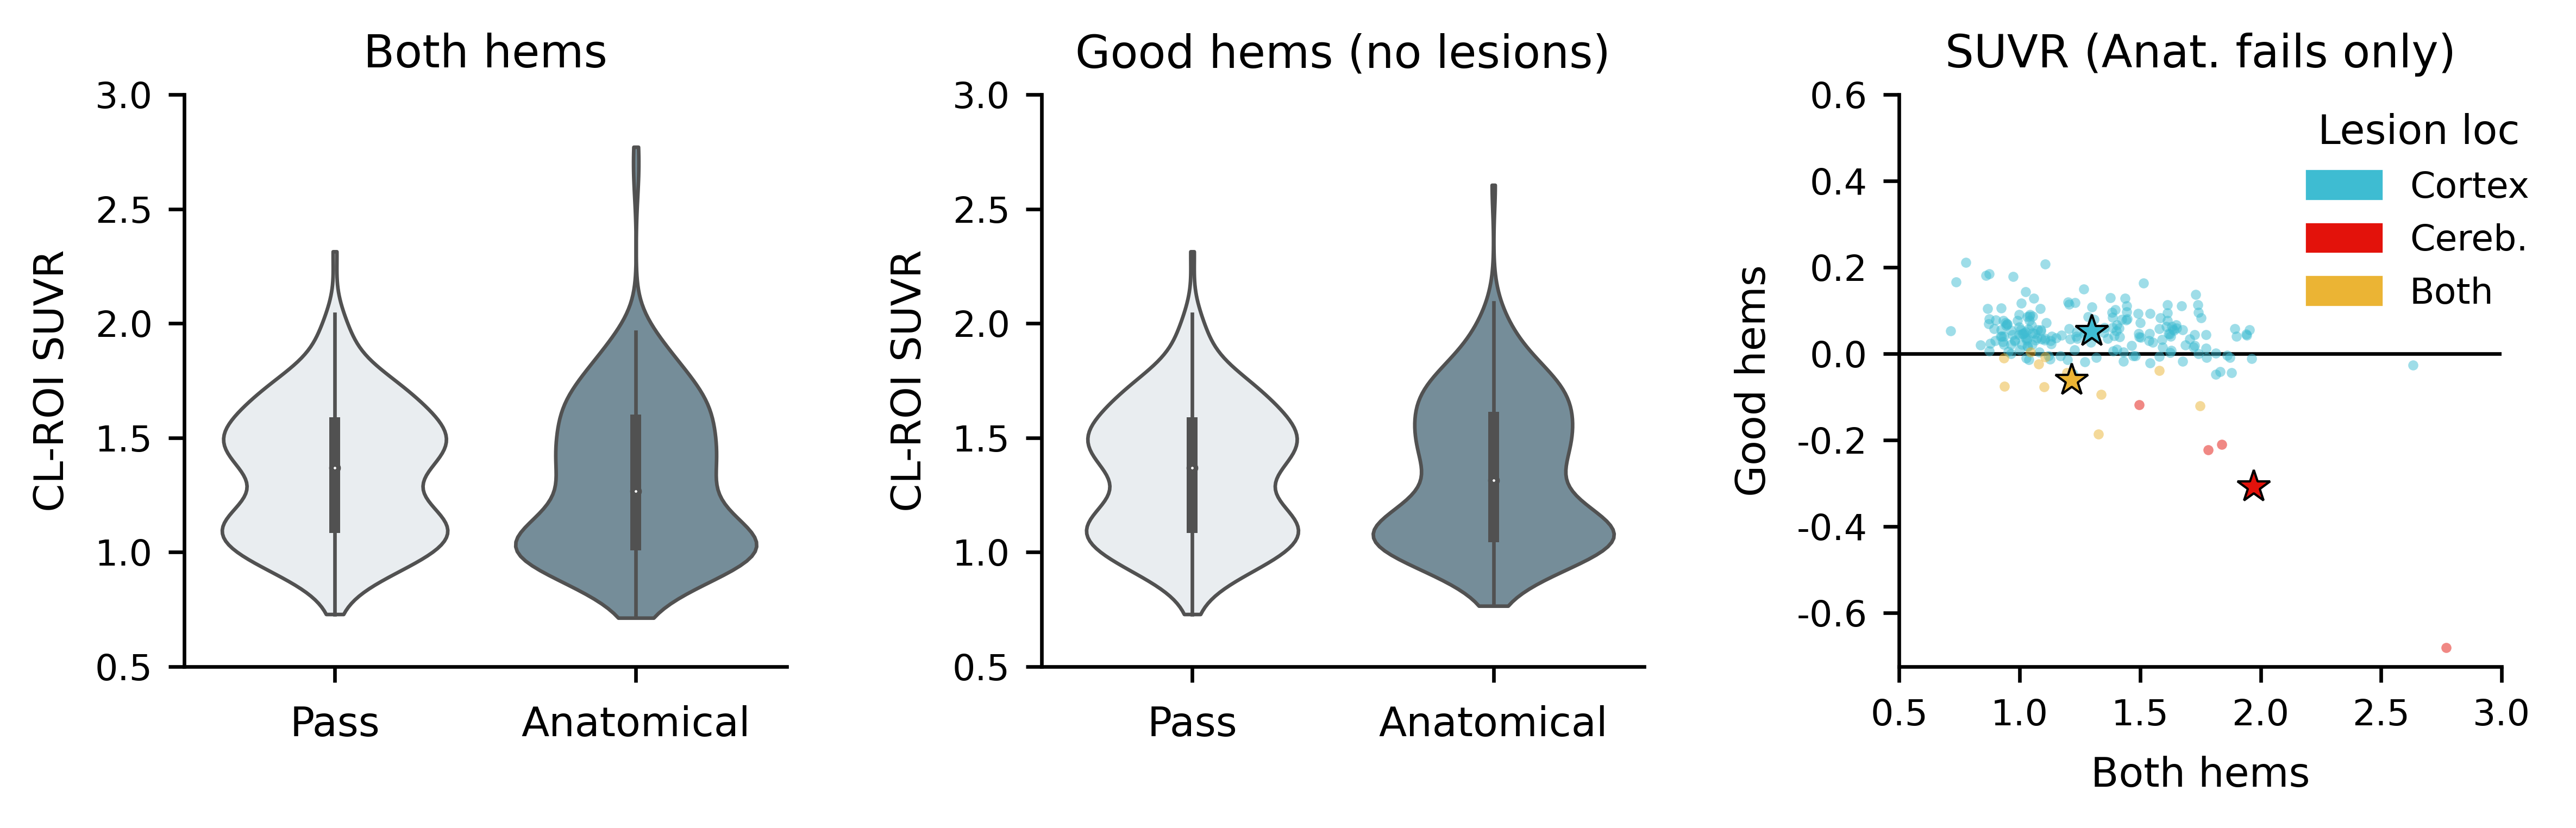

In [355]:
# Plot the centiloid region ROI distribution for pass and anat fail scans.
ylim = [0.5, 3]
yticks = np.linspace(ylim[0], ylim[1], 6)
xlim = ylim
xticks = yticks
size = 5
lw = 0.8
alpha = 0.5
labelpad = 5
font = {"tick": 8, "label": 9, "fig": 10}
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=(8, 8 * 0.33), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[_idx, :],
    x="qc_cat",
    y="cl_suvr",
    lw=lw,
    order=["Pass", "Anatomical"],
    # color=co["gray"],
    edgecolor="k",
    palette=[co["lgray"], co["dgray"]],
    cut=0,
    saturation=1,
    linewidth=lw,
    ax=_ax,
)
_ax.tick_params(axis="x", labelsize=font["label"], pad=5)
_ax.tick_params(axis="y", labelsize=font["tick"])
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks)
_ax.set_xlabel("", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("CL-ROI SUVR", fontsize=font["label"], labelpad=labelpad)
_ax.set_title("Both hems", fontsize=font["fig"])

iax = 1
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[_idx, :],
    x="qc_cat",
    y="cl_suvr_adj",
    lw=lw,
    order=["Pass", "Anatomical"],
    # color=co["blue"],
    edgecolor='k',
    palette=[co["lgray"], co["dgray"]],
    cut=0,
    saturation=1,
    linewidth=lw,
    ax=_ax,
)
_ax.tick_params(axis="x", labelsize=font["label"], pad=5)
_ax.tick_params(axis="y", labelsize=font["tick"])
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks)
_ax.set_xlabel("", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("CL-ROI SUVR", fontsize=font["label"], labelpad=labelpad)
_ax.set_title("Good hems (no lesions)", fontsize=font["fig"])

iax = 2
_ax = ax[iax]
# _ax.plot(yticks, yticks, color="k", lw=lw, zorder=0)
_ax.axhline(0, lw=lw, color="k", zorder=0)
qry = {
    "rr_only": "(qc_cat=='Anatomical') & (qref_region_affected==1) & (qcl_roi_affected==0)",
    "cl_only": "(qc_cat=='Anatomical') & (qref_region_affected==0) & (qcl_roi_affected==1)",
    "both": "(qc_cat=='Anatomical') & (qref_region_affected==1) & (qcl_roi_affected==1)",
}
for _qry, _color in [
    ("rr_only", co["red"]),
    ("cl_only", co["cyan"]),
    ("both", co["yellow"]),
]:
    __idx = ideas_qc.query(qry[_qry]).index
    _ax.scatter(
        x=ideas_qc.loc[__idx, "cl_suvr"],
        y=ideas_qc.loc[__idx, "cl_suvr_adj"] - ideas_qc.loc[__idx, "cl_suvr"],
        s=size,
        color=_color,
        alpha=alpha,
        lw=0,
        ec="k",
    )
    centroid = [
        np.mean(ideas_qc.loc[__idx, "cl_suvr"]),
        np.mean(ideas_qc.loc[__idx, "cl_suvr_adj"] - ideas_qc.loc[__idx, "cl_suvr"]),
    ]
    _ax.plot(
        [centroid[0]],
        [centroid[1]],
        marker="*",
        ms=7.5,
        lw=1,
        color=_color,
        mec="k",
        mew=0.5,
    )
ylim = [-0.7, 0.7]
yticks = np.round(np.linspace(-0.6, 0.6, 7), 1)
_ax.tick_params(labelsize=font["tick"])
# _ax.set_aspect(1)
# _ax.set_xlim(ylim)
# _ax.set_ylim(ylim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticks)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks)
_ax.set_xlabel("Both hems", fontsize=font["label"], labelpad=labelpad)
_ax.set_ylabel("Good hems", fontsize=font["label"], labelpad=labelpad)
_colors = [co["cyan"], co["red"], co["yellow"]]
_labels = ["Cortex", "Cereb.", "Both"]
circles = [plt.Circle((0, 0), 1, color=color) for color in _colors]
_ax.legend(circles, _labels, loc=1, fontsize=font['tick'], title='Lesion loc', title_fontsize=font['label'],
           frameon=False, bbox_to_anchor=[1.1, 1.025])
_ax.set_title("SUVR (Anat. fails only)", fontsize=font["fig"])

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)
fig.tight_layout(w_pad=2)
figfile = op.join(figs_dir, "anatomical_fail_fix.png")
fig.savefig(figfile)
print('Saved {}'.format(figfile))
plt.show()

# Analyze missing data

In [57]:
# Load the IDEAS QC spreadsheet.
ideas_qcf = op.join(
    "/Users/dschonhaut/Box/IDEAS_QC_FINAL/Date_2022-11-08",
    "IDEAS_paths_ratings_N10700.xlsx",
)
browse_cols = ["QC_rating", "Consensus_rating", "Fail_Subcategory"]
keep_cols = ["qc_cat", "wmeanf", "QC_rating", "Consensus_rating", "Fail_Subcategory"]
# -----------------------

# Load the QC scan spreadsheet.
ideas_qc = pd.read_excel(ideas_qcf)
assert len(ideas_qc) == ideas_qc["ID"].nunique()
ideas_qc.set_index("ID", inplace=True)

# Group scans by QC category.
qc_cats = pd.Series(
    {
        "pass": ideas_qc.query("(QC_rating=='Pass-Pass') | (Consensus_rating=='Pass')")
        .index.unique()
        .tolist(),
        "fail_anatomical": ideas_qc.query("(Fail_Subcategory=='Anatomical')")
        .index.unique()
        .tolist(),
        "fail_fovref": ideas_qc.query("(Fail_Subcategory=='FOV-Ref')")
        .index.unique()
        .tolist(),
    }
)
for cat1, cat2 in itertools.combinations(qc_cats.index, 2):
    assert len(set(qc_cats[cat1]) & set(qc_cats[cat2])) == 0
ideas_qc.insert(0, "qc_cat", np.nan)
for qc_cat, subjs in qc_cats.items():
    ideas_qc.loc[np.isin(ideas_qc.index, subjs), "qc_cat"] = qc_cat
qc_idx = ideas_qc["qc_cat"].dropna().index

# Add paths to the warped mean images.
assert (
    ideas_qc["path_to_warpednii_Qced"]
    .apply(lambda x: op.exists(op.join(pet_dir, op.basename(x))))
    .all()
)
ideas_qc.insert(
    1,
    "wmeanf",
    ideas_qc["path_to_warpednii_Qced"].apply(
        lambda x: op.join(pet_dir, op.basename(x))
    ),
)
ideas_qc = ideas_qc.loc[:, keep_cols]

# Print some basic info
print("ideas_qc: {}".format(ideas_qc.shape))
print("scans with qc_cat: {}".format(qc_idx.size))
print("")
for col in browse_cols:
    print(ideas_qc.groupby(col).size(), end="\n" * 2)
for k in qc_cats.index:
    print("{:>4} {} scans".format(len(qc_cats[k]), k))
print("")
display(ideas_qc.iloc[np.r_[0:5, -5:0], :])

In [51]:
start = time()
new_cols = [
    "halo_thresh",
    "ctx_suvr",
    "wb_suvr",
    "rr_missing",
    "ctx_missing",
    "wb_missing",
]
save_missing_img = False
overwrite = False
verbose = False
# -----------------------------

for col in new_cols:
    ideas_qc[col] = np.nan

for subj in qc_idx:
    petf = ideas_qc.at[subj, "wmeanf"]
    suvr = create_suvr(petf, rois_idx["rr"])

    ideas_qc.at[subj, "halo_thresh"] = get_halo_thresh(suvr, halo_idx, 2)
    ideas_qc.at[subj, "ctx_suvr"] = vox_mean(suvr, ctx_idx)
    ideas_qc.at[subj, "wb_suvr"] = vox_mean(suvr, wb_idx)

    suvr_lt_thresh = suvr < ideas_qc.at[subj, "halo_thresh"]
    ideas_qc.at[subj, "rr_missing"] = (
        np.count_nonzero(np.all((rr_gt0, suvr_lt_thresh), axis=0)) / rr_idx[0].size
    )
    ideas_qc.at[subj, "ctx_missing"] = (
        np.count_nonzero(np.all((ctx_gt0, suvr_lt_thresh), axis=0)) / ctx_idx[0].size
    )
    ideas_qc.at[subj, "wb_missing"] = (
        np.count_nonzero(np.all((wb_gt0, suvr_lt_thresh), axis=0)) / wb_idx[0].size
    )

    if save_missing_img:
        missing_roif = op.join(missingvox_dir, "w{}_missing-voxels.nii".format(subj))
        missing_roi = get_missing_roi(
            suvr, _affine, _hdr, missing_roif, overwrite=overwrite, verbose=verbose
        )

print("Done in {:.2f}s".format(time() - start))

Done in 315.46s


In [5]:
# Save/load the updated QC dataframe.
overwrite = False
# ------------------------

ideas_qc_outf = op.join(data_dir, "metadata", "ideas_qc.csv")
if overwrite or not op.exists(ideas_qc_outf):
    ideas_qc.to_csv(ideas_qc_outf)
    print("Saved {}".format(ideas_qc_outf))
else:
    ideas_qc = pd.read_csv(ideas_qc_outf)
    ideas_qc.set_index("ID", inplace=True)
    assert ideas_qc.index.nunique() == len(ideas_qc)
    print("Loaded ideas_qc, shape: {}".format(ideas_qc.shape))

Loaded ideas_qc, shape: (10700, 11)


In [62]:
arr1 = create_suvr(ideas_qc.iloc[0]["wmeanf"], rois_idx["rr"], verbose=True)
arr2 = create_suvr(ideas_qc.iloc[0]["wmeanf"], ref_regionf, verbose=True)
arr3 = create_suvr(ideas_qc.iloc[0]["wmeanf"], rois["rr"], verbose=True)
arr4 = create_suvr(ideas_qc.iloc[0]["wmeanf"], rois_gt0["rr"], verbose=True)
print(
    np.array_equal(arr1, arr2),
    np.array_equal(arr1, arr3),
    np.array_equal(arr1, arr4),
    np.array_equal(arr2, arr3),
    np.array_equal(arr2, arr4),
    np.array_equal(arr3, arr4),
)

Ref. region mean = 1985.03
Ref. region mean = 1985.03
Ref. region mean = 1985.03
Ref. region mean = 1985.03
True True True True True True


In [62]:
def mean_ci(x):
    return "{:.3f} (CI={:.3f}-{:.3f}, min={:.3f}, max={:.3f})".format(
        np.mean(x),
        np.mean(x) - (1.96 * stats.sem(x)),
        np.mean(x) + (1.96 * stats.sem(x)),
        np.min(x),
        np.max(x),
    )


(
    ideas_qc.loc[qc_idx, :]
    .groupby("qc_cat")
    .agg(
        {
            "wmeanf": len,
            "halo_thresh": mean_ci,
            "ctx_suvr": mean_ci,
            "wb_suvr": mean_ci,
            "rr_missing": lambda x: mean_ci(x * 100),
            "ctx_missing": lambda x: mean_ci(x * 100),
            "wb_missing": lambda x: mean_ci(x * 100),
        }
    )
)

,wmeanf,halo_thresh,ctx_suvr,wb_suvr,rr_missing,ctx_missing,wb_missing
qc_cat,,,,,,,
fail_anatomical,267,"0.059 (CI=0.053-0.065, min=0.004, max=0.518)","1.304 (CI=1.262-1.346, min=0.701, max=2.771)","1.188 (CI=1.164-1.212, min=0.820, max=2.224)","0.136 (CI=0.003-0.268, min=0.000, max=13.608)","0.049 (CI=-0.011-0.110, min=0.000, max=8.074)","0.156 (CI=0.035-0.276, min=0.000, max=12.708)"
fail_fovref,120,"0.066 (CI=0.058-0.073, min=0.015, max=0.286)","1.376 (CI=1.320-1.432, min=0.905, max=2.328)","1.218 (CI=1.187-1.250, min=0.951, max=1.952)","1.838 (CI=0.965-2.711, min=0.000, max=38.641)","0.002 (CI=-0.001-0.004, min=0.000, max=0.160)","0.553 (CI=0.428-0.678, min=0.045, max=4.912)"
pass,9827,"0.052 (CI=0.051-0.052, min=0.002, max=0.543)","1.354 (CI=1.348-1.360, min=0.701, max=2.518)","1.226 (CI=1.222-1.229, min=0.858, max=1.915)","0.009 (CI=0.004-0.013, min=0.000, max=15.288)","0.001 (CI=0.000-0.001, min=0.000, max=3.171)","0.012 (CI=0.009-0.014, min=0.000, max=9.360)"


In [66]:
# ideas_qc.loc[ideas_qc['qc_cat']=='pass', 'halo_thresh']

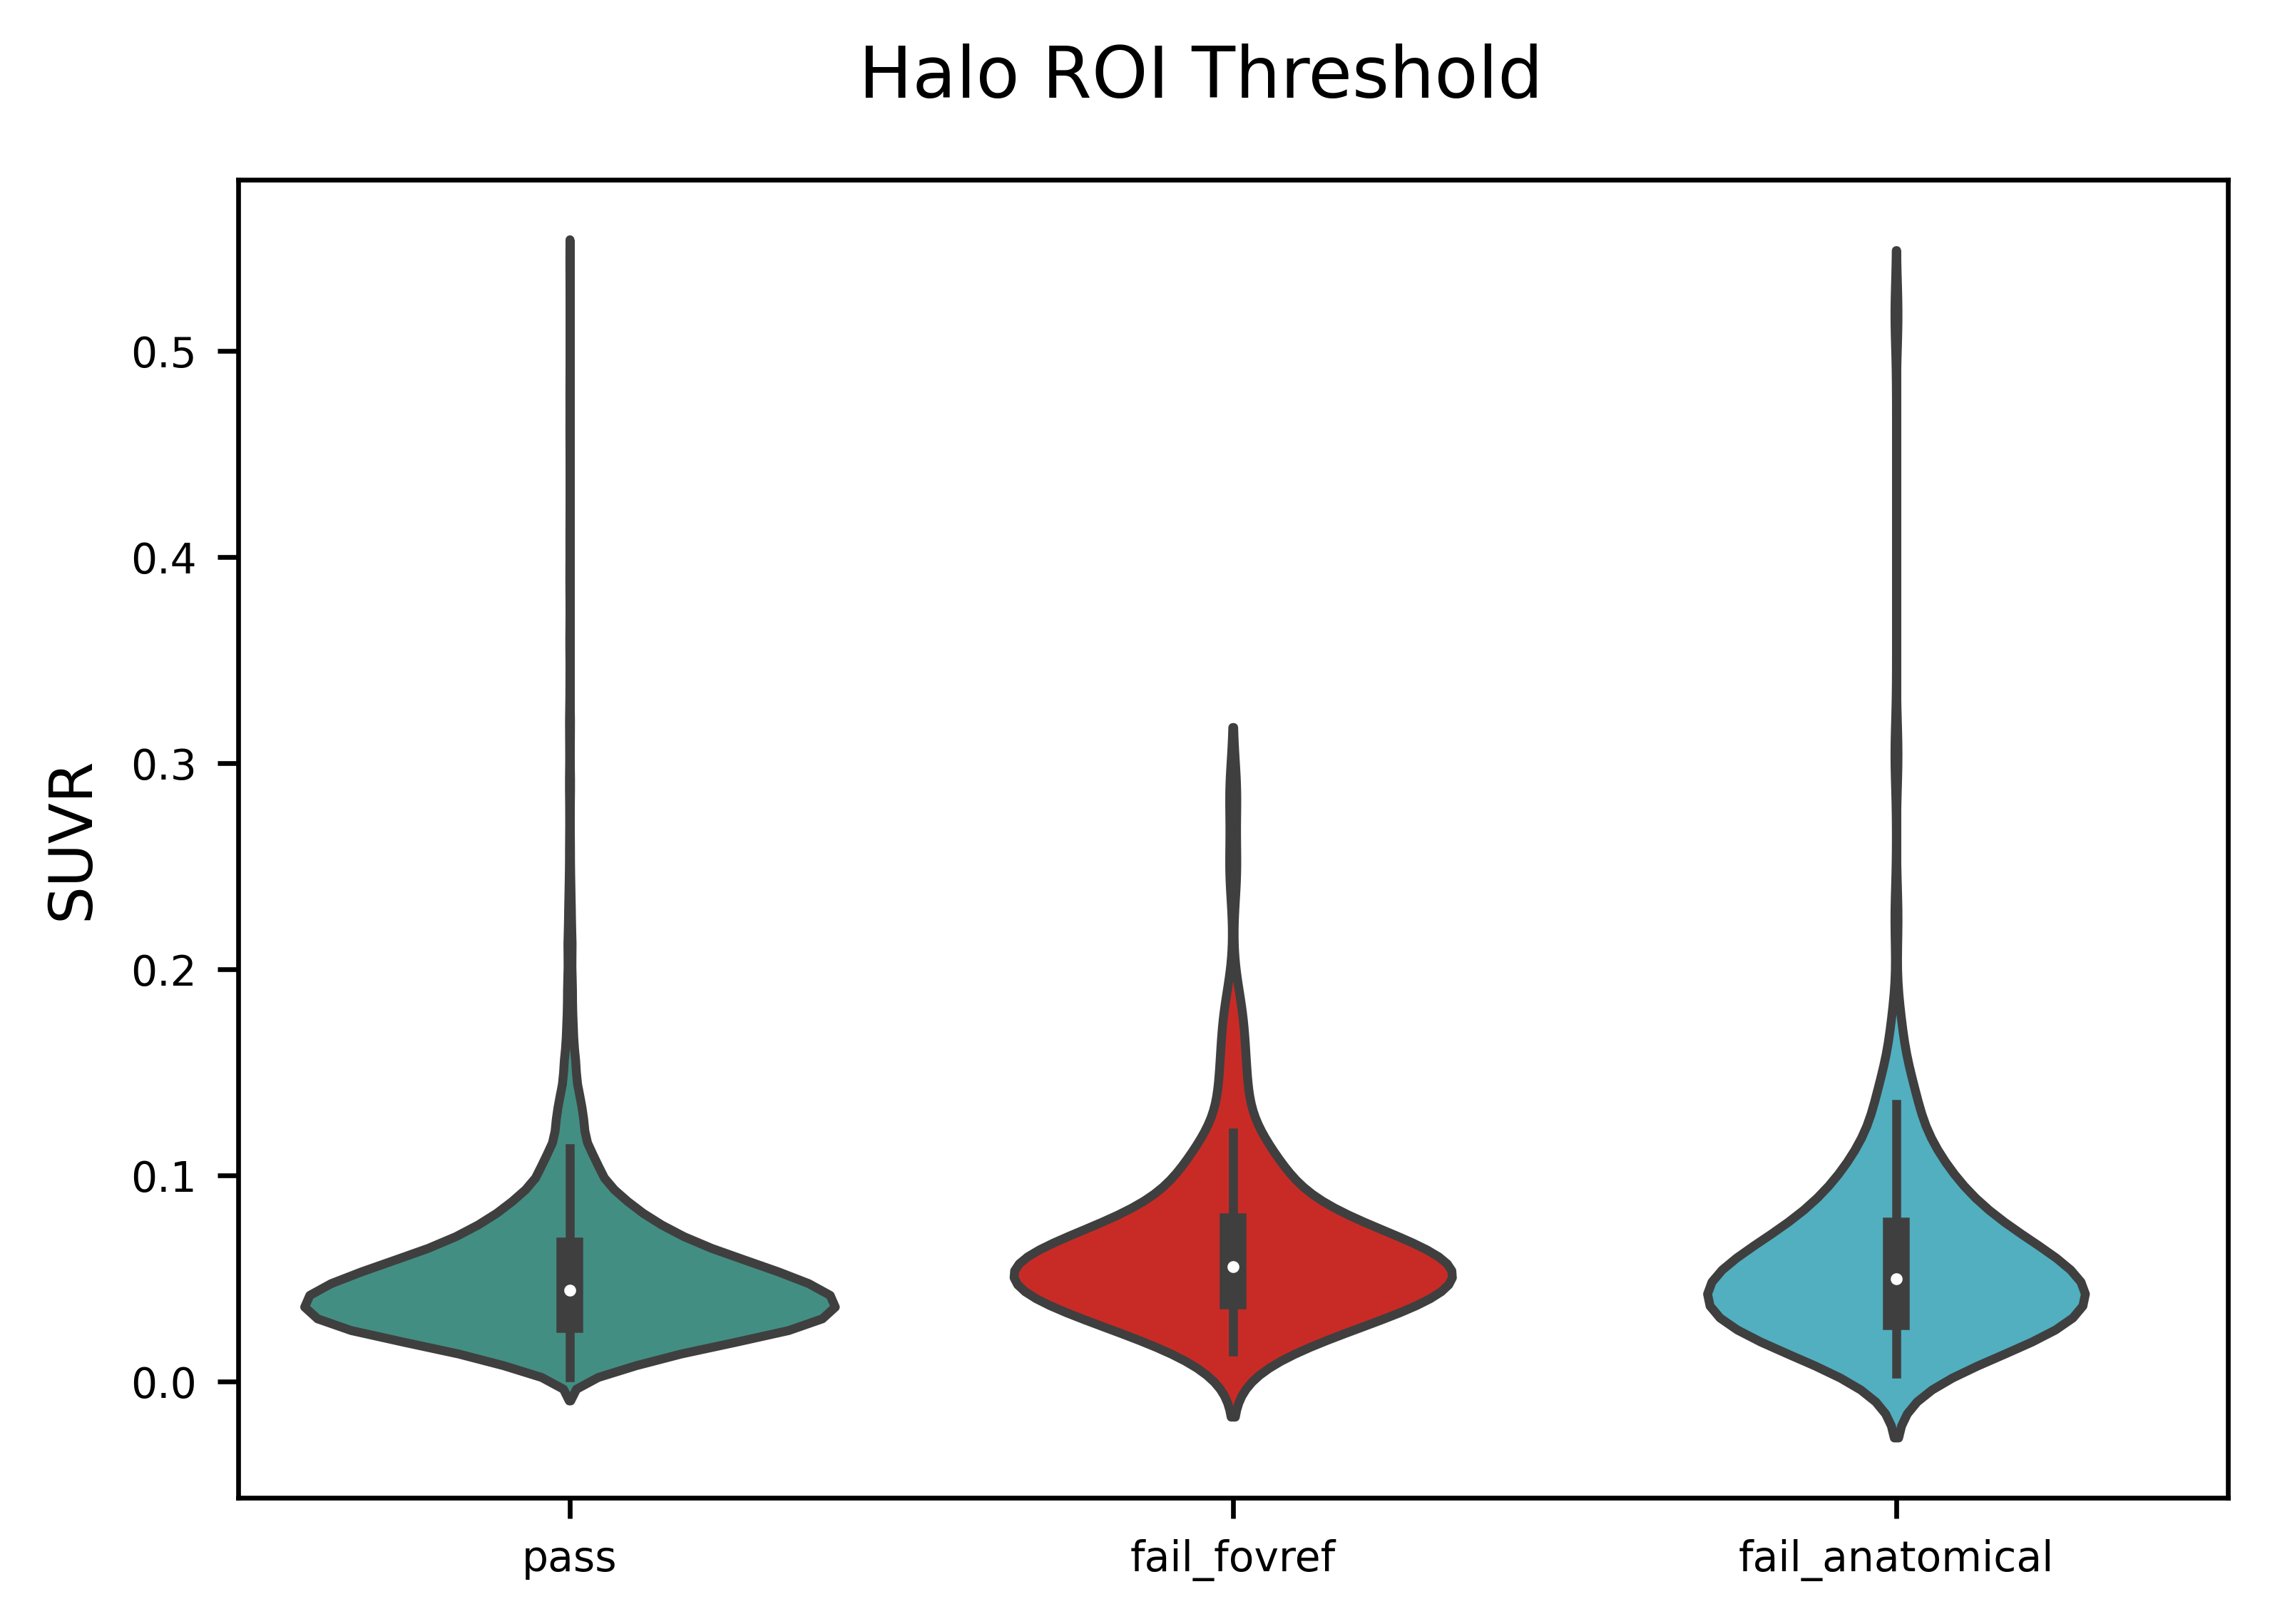

In [106]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="halo_thresh",
    lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("SUVR", labelpad=labelpad)
fig.suptitle("Halo ROI Threshold", y=0.96)

plt.show()

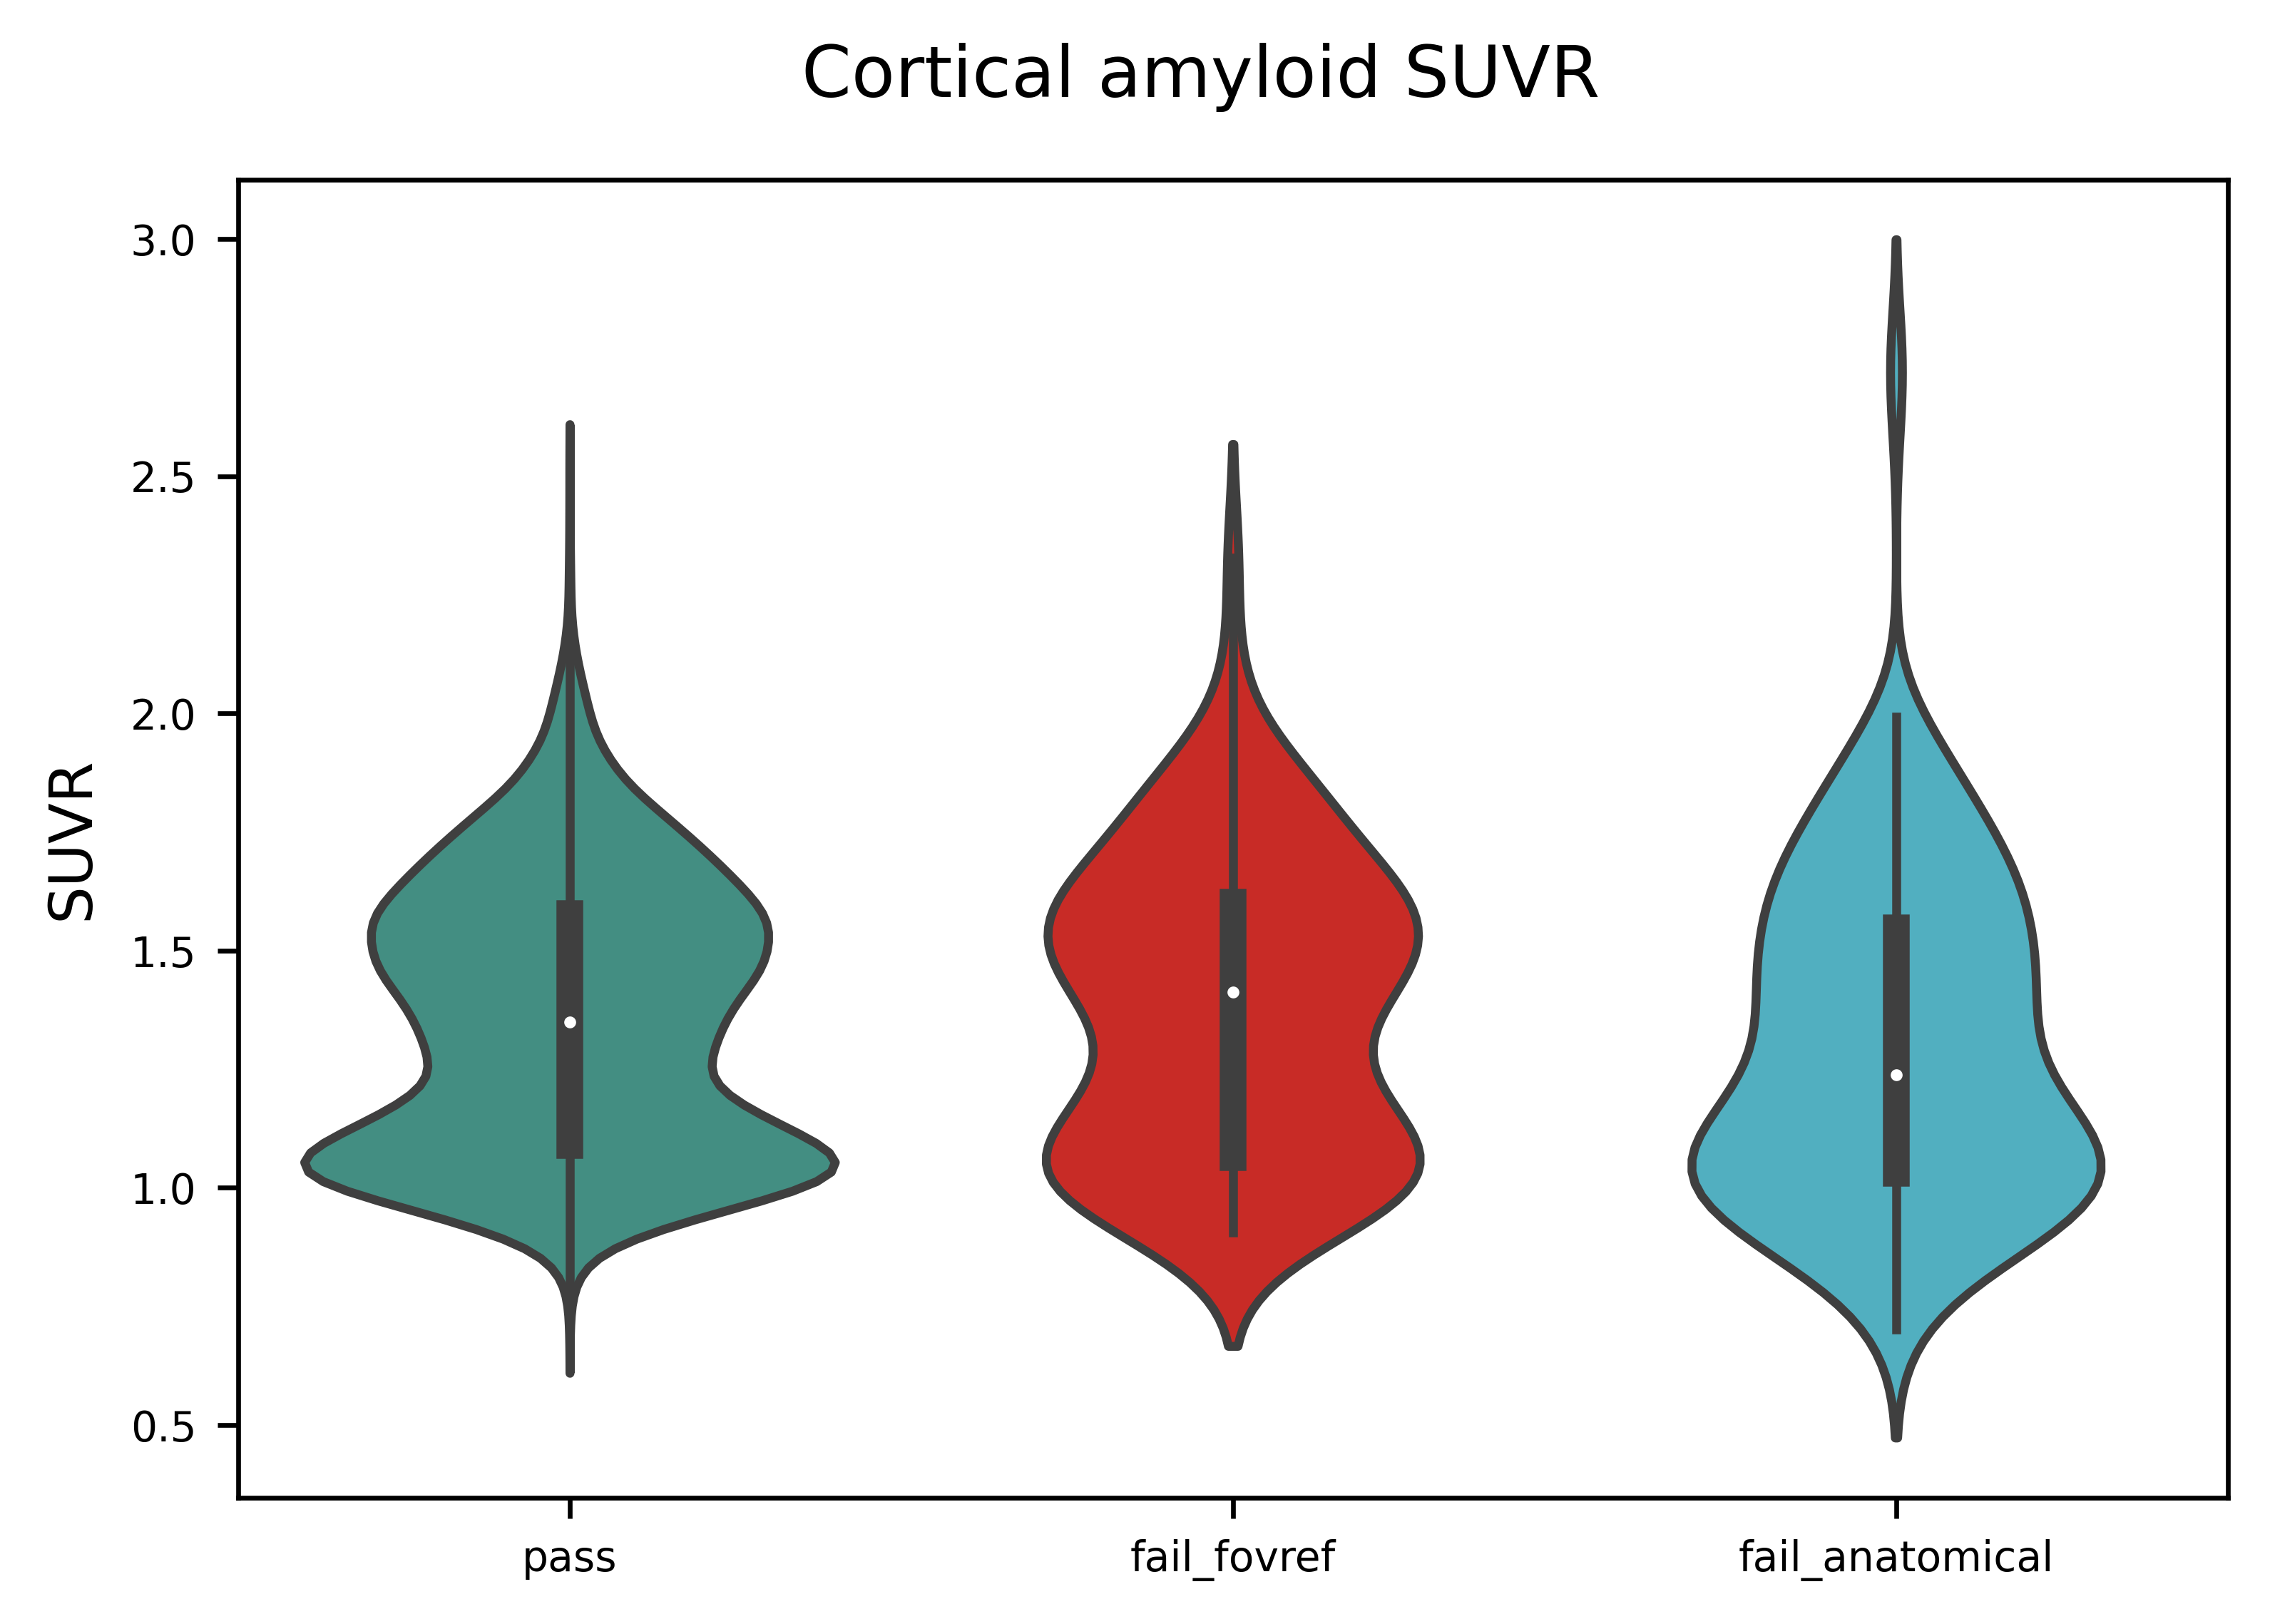

In [105]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.violinplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="ctx_suvr",
    lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("SUVR", labelpad=labelpad)
fig.suptitle("Cortical amyloid SUVR", y=0.96)

plt.show()

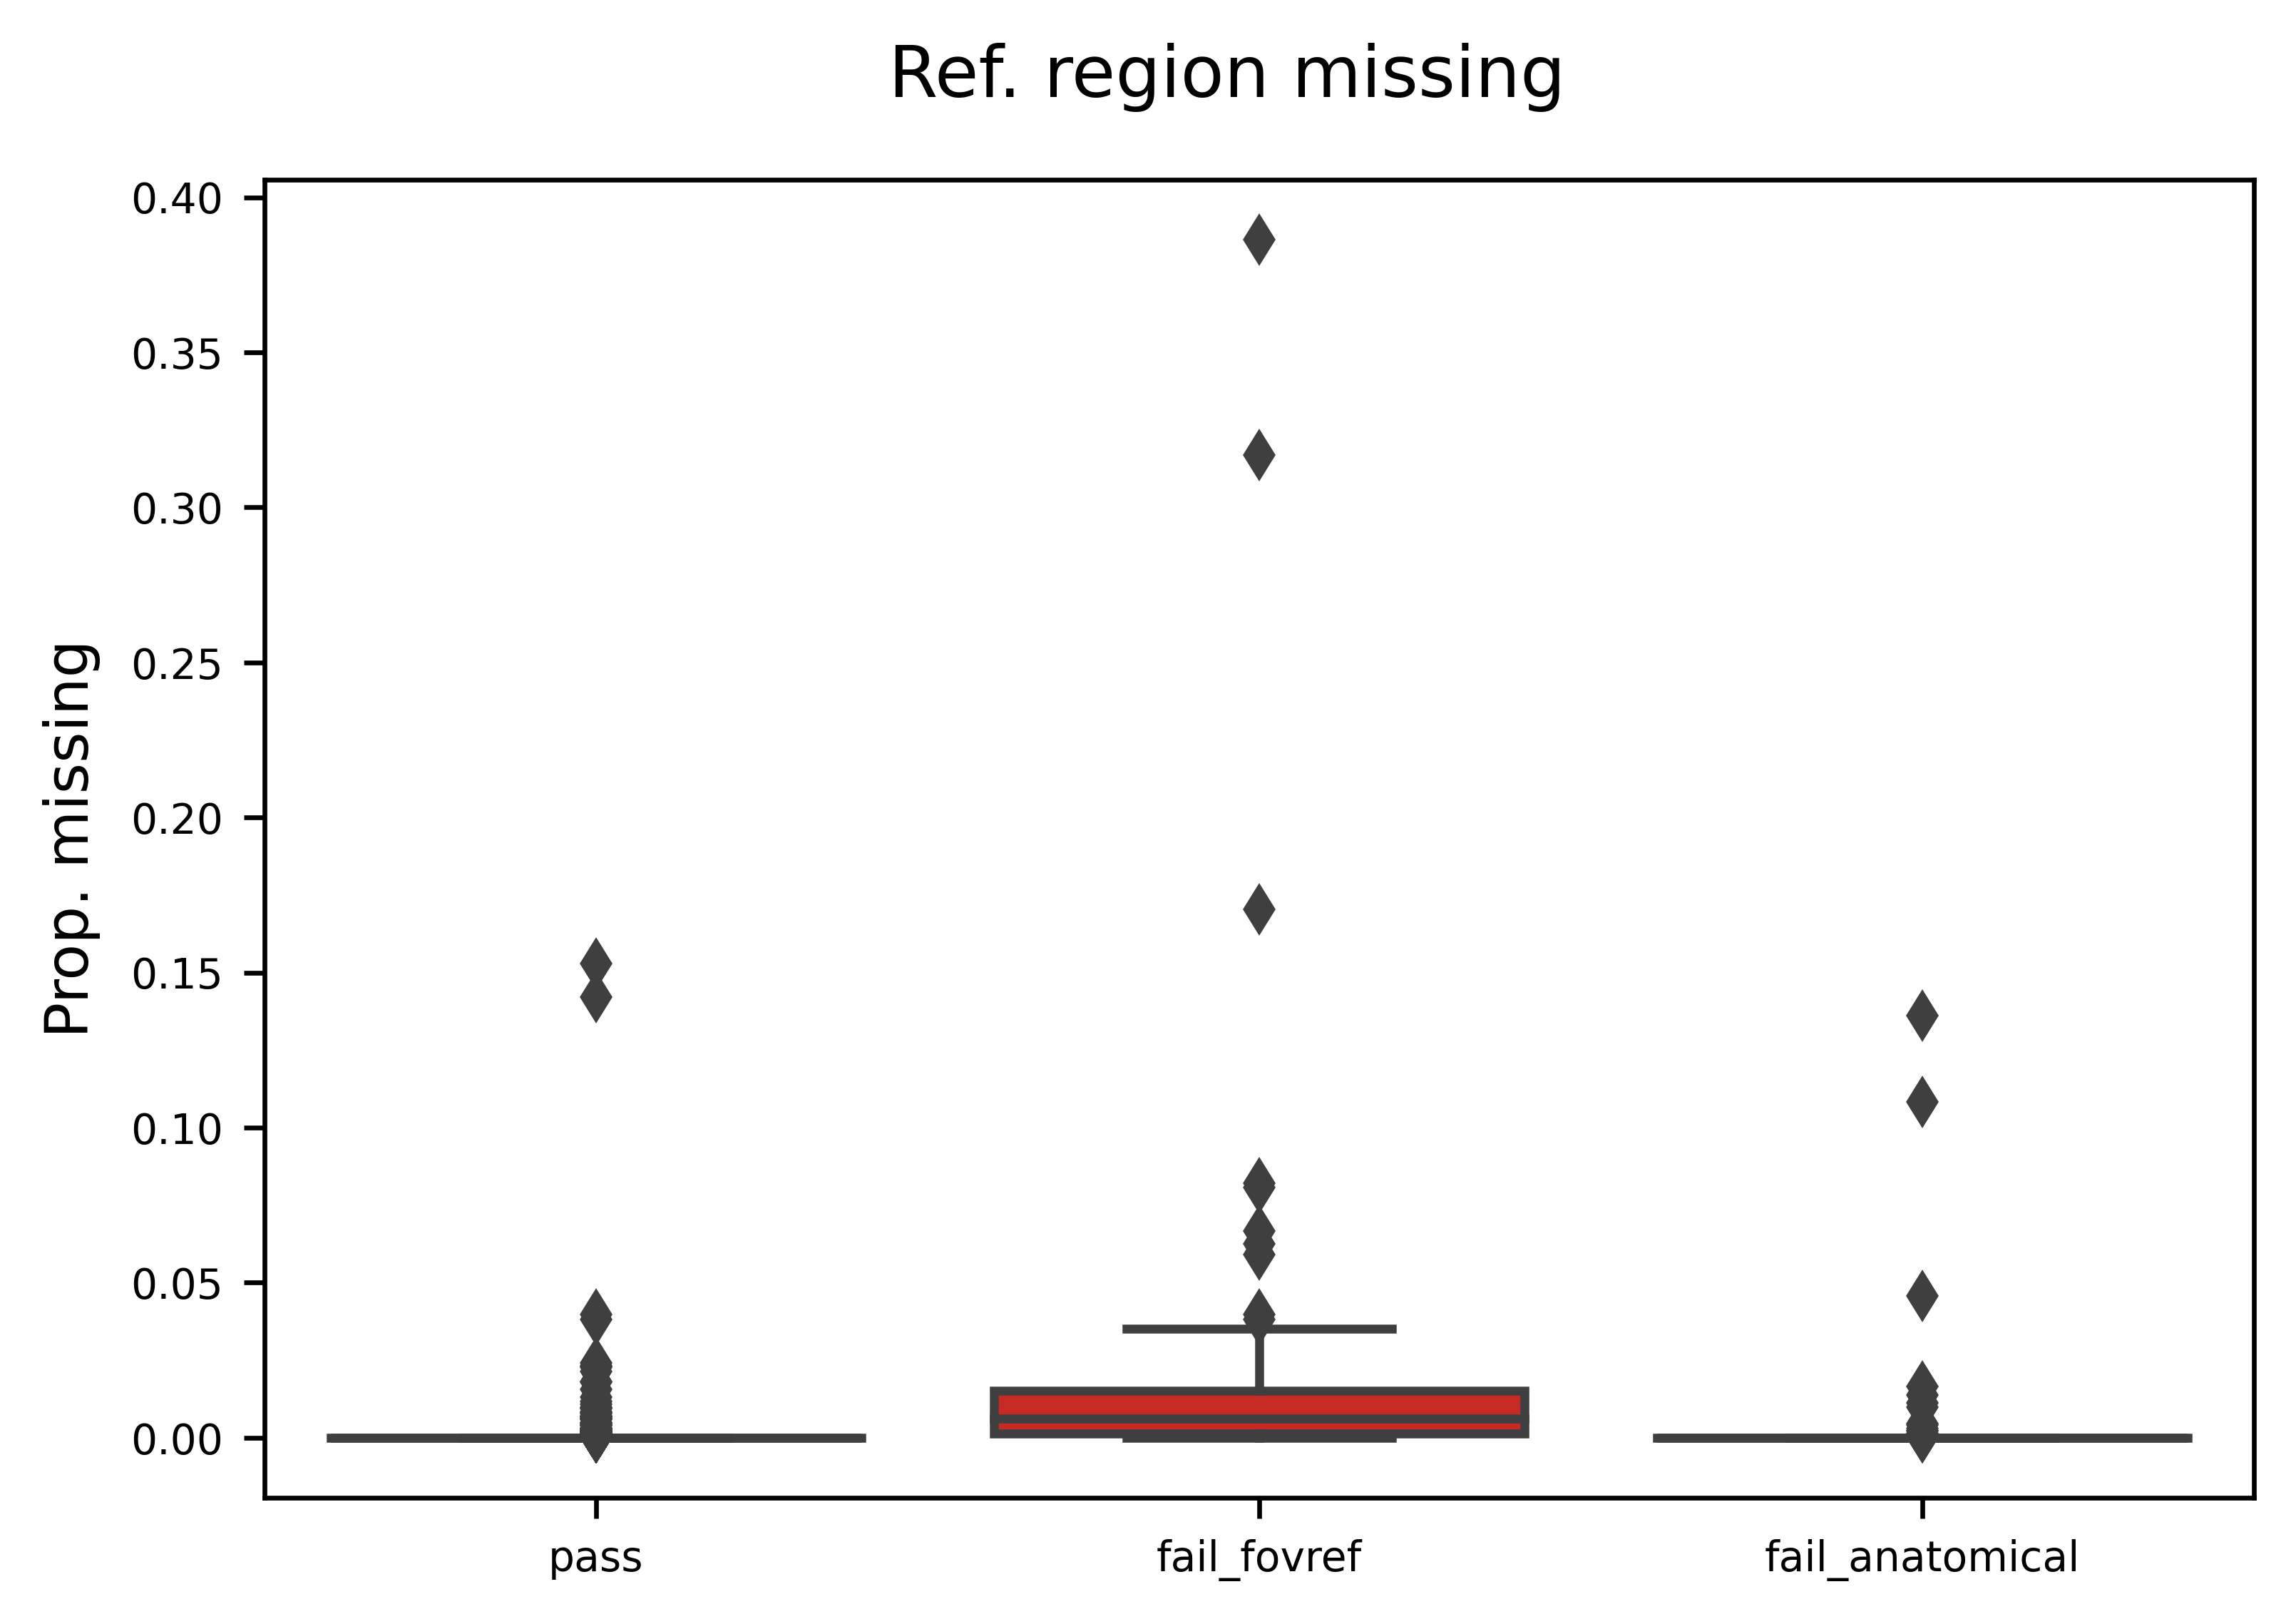

In [118]:
alpha = 0.5
labelpad = 5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.boxplot(
    data=ideas_qc.loc[qc_idx, :],
    x="qc_cat",
    y="rr_missing",  # lw=0.5,
    order=["pass", "fail_fovref", "fail_anatomical"],
    palette=[co["green"], co["red"], co["cyan"]],
)
_ax.tick_params(labelsize=7)
_ax.set_xlabel("", labelpad=labelpad)
_ax.set_ylabel("Prop. missing", labelpad=labelpad)
fig.suptitle("Ref. region missing", y=0.96)

plt.show()

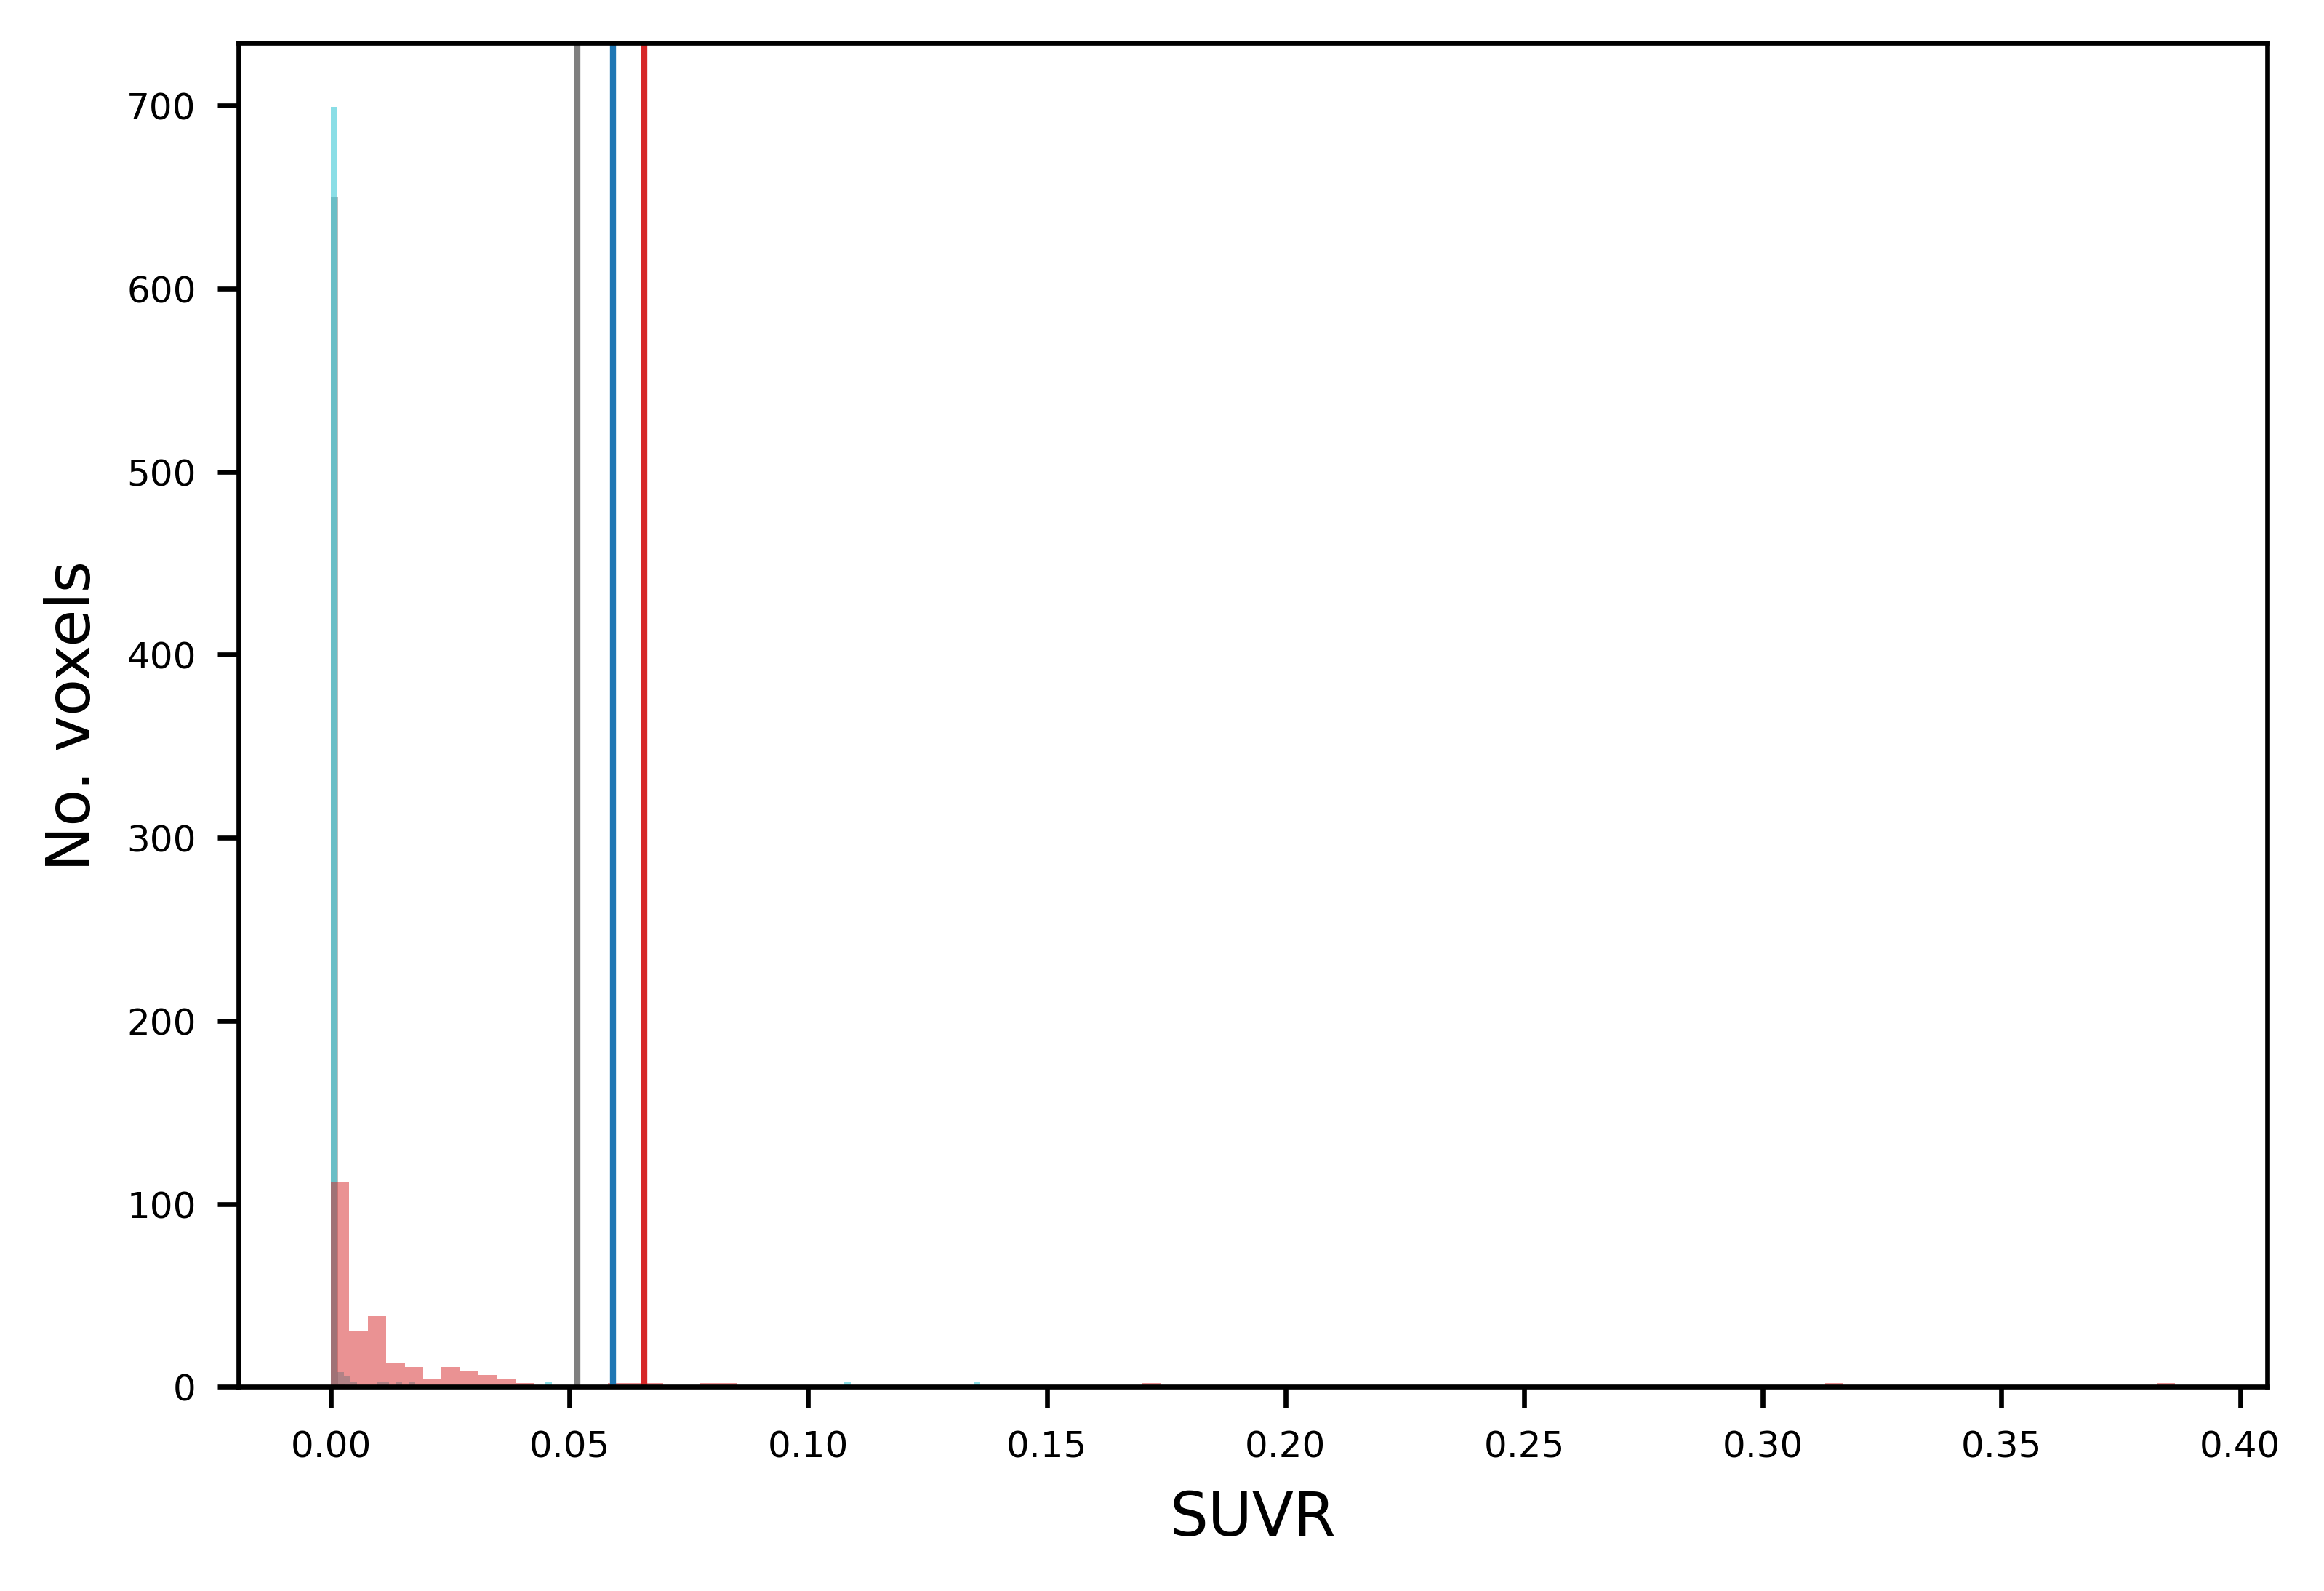

In [110]:
alpha = 0.5
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "pass", "rr_missing"],
    bins=100,
    color="tab:gray",
    alpha=alpha,
    density=True,
)
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "fail_anatomical", "rr_missing"],
    bins=100,
    color="tab:cyan",
    alpha=alpha,
    density=True,
)
_ax.hist(
    ideas_qc.loc[ideas_qc["qc_cat"] == "fail_fovref", "rr_missing"],
    bins=100,
    color="tab:red",
    alpha=alpha,
    density=True,
)

_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "pass", "halo_thresh"]),
    color="tab:gray",
    lw=1,
)
_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "fail_anatomical", "halo_thresh"]),
    color="tab:blue",
    lw=1,
)
_ax.axvline(
    np.mean(ideas_qc.loc[ideas_qc["qc_cat"] == "fail_fovref", "halo_thresh"]),
    color="tab:red",
    lw=1,
)
# _ax.set_yscale('log')
_ax.tick_params(labelsize=6)
_ax.set_xlabel("SUVR")
_ax.set_ylabel("No. voxels")


plt.show()

In [52]:
# Load PET.
subj = 52468
# ---------------------------

petf = ideas_qc.at[subj, "wmeanf"]
suvr = create_suvr(nii2arr(petf), rr_idx)
halo_thresh = get_halo_thresh(suvr, halo_idx, 2)

print("Missing voxel cutoff = {:.3f}".format(halo_thresh))

Missing voxel cutoff = 0.045


In [266]:
outfile = op.join(
    missingvox_dir, op.basename(petf).replace(".nii", "_missing-voxels.nii")
)
overwrite = False
# -------------------------

# Save a nifti image for the missing voxels.
missing_roi = np.zeros(pet.shape, dtype=np.byte)

# Ref. region missing = 1
idx = np.all((ref_region > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 1

# Cortical amyloid region missing = 2
idx = np.all((cl_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 2

# Remaining brain missing = 3
idx = np.all((wb_roi > 0, pet < halo_thresh, missing_roi == 0), axis=0)
missing_roi[idx] = 3

# Save the file as a new image.
if overwrite or not op.exists(missingvox_dir):
    newimg = nib.Nifti1Image(
        missing_roi, pet_img.affine, pet_img.header, dtype=missing_roi.dtype
    )
    newimg.to_filename(outfile)
    print("Saved {}".format(outfile))

Saved /Users/dschonhaut/data/IDEAS_FullAnalysis/missing_voxels/w52468_missing-voxels.nii


Missing voxel cutoff = 0.045
Missing  2,417 (1.17%) voxels in the brain
Missing    882 (5.90%) voxels in the ref. region
Missing      0 (0.00%) voxels in the pos-amyloid ROI


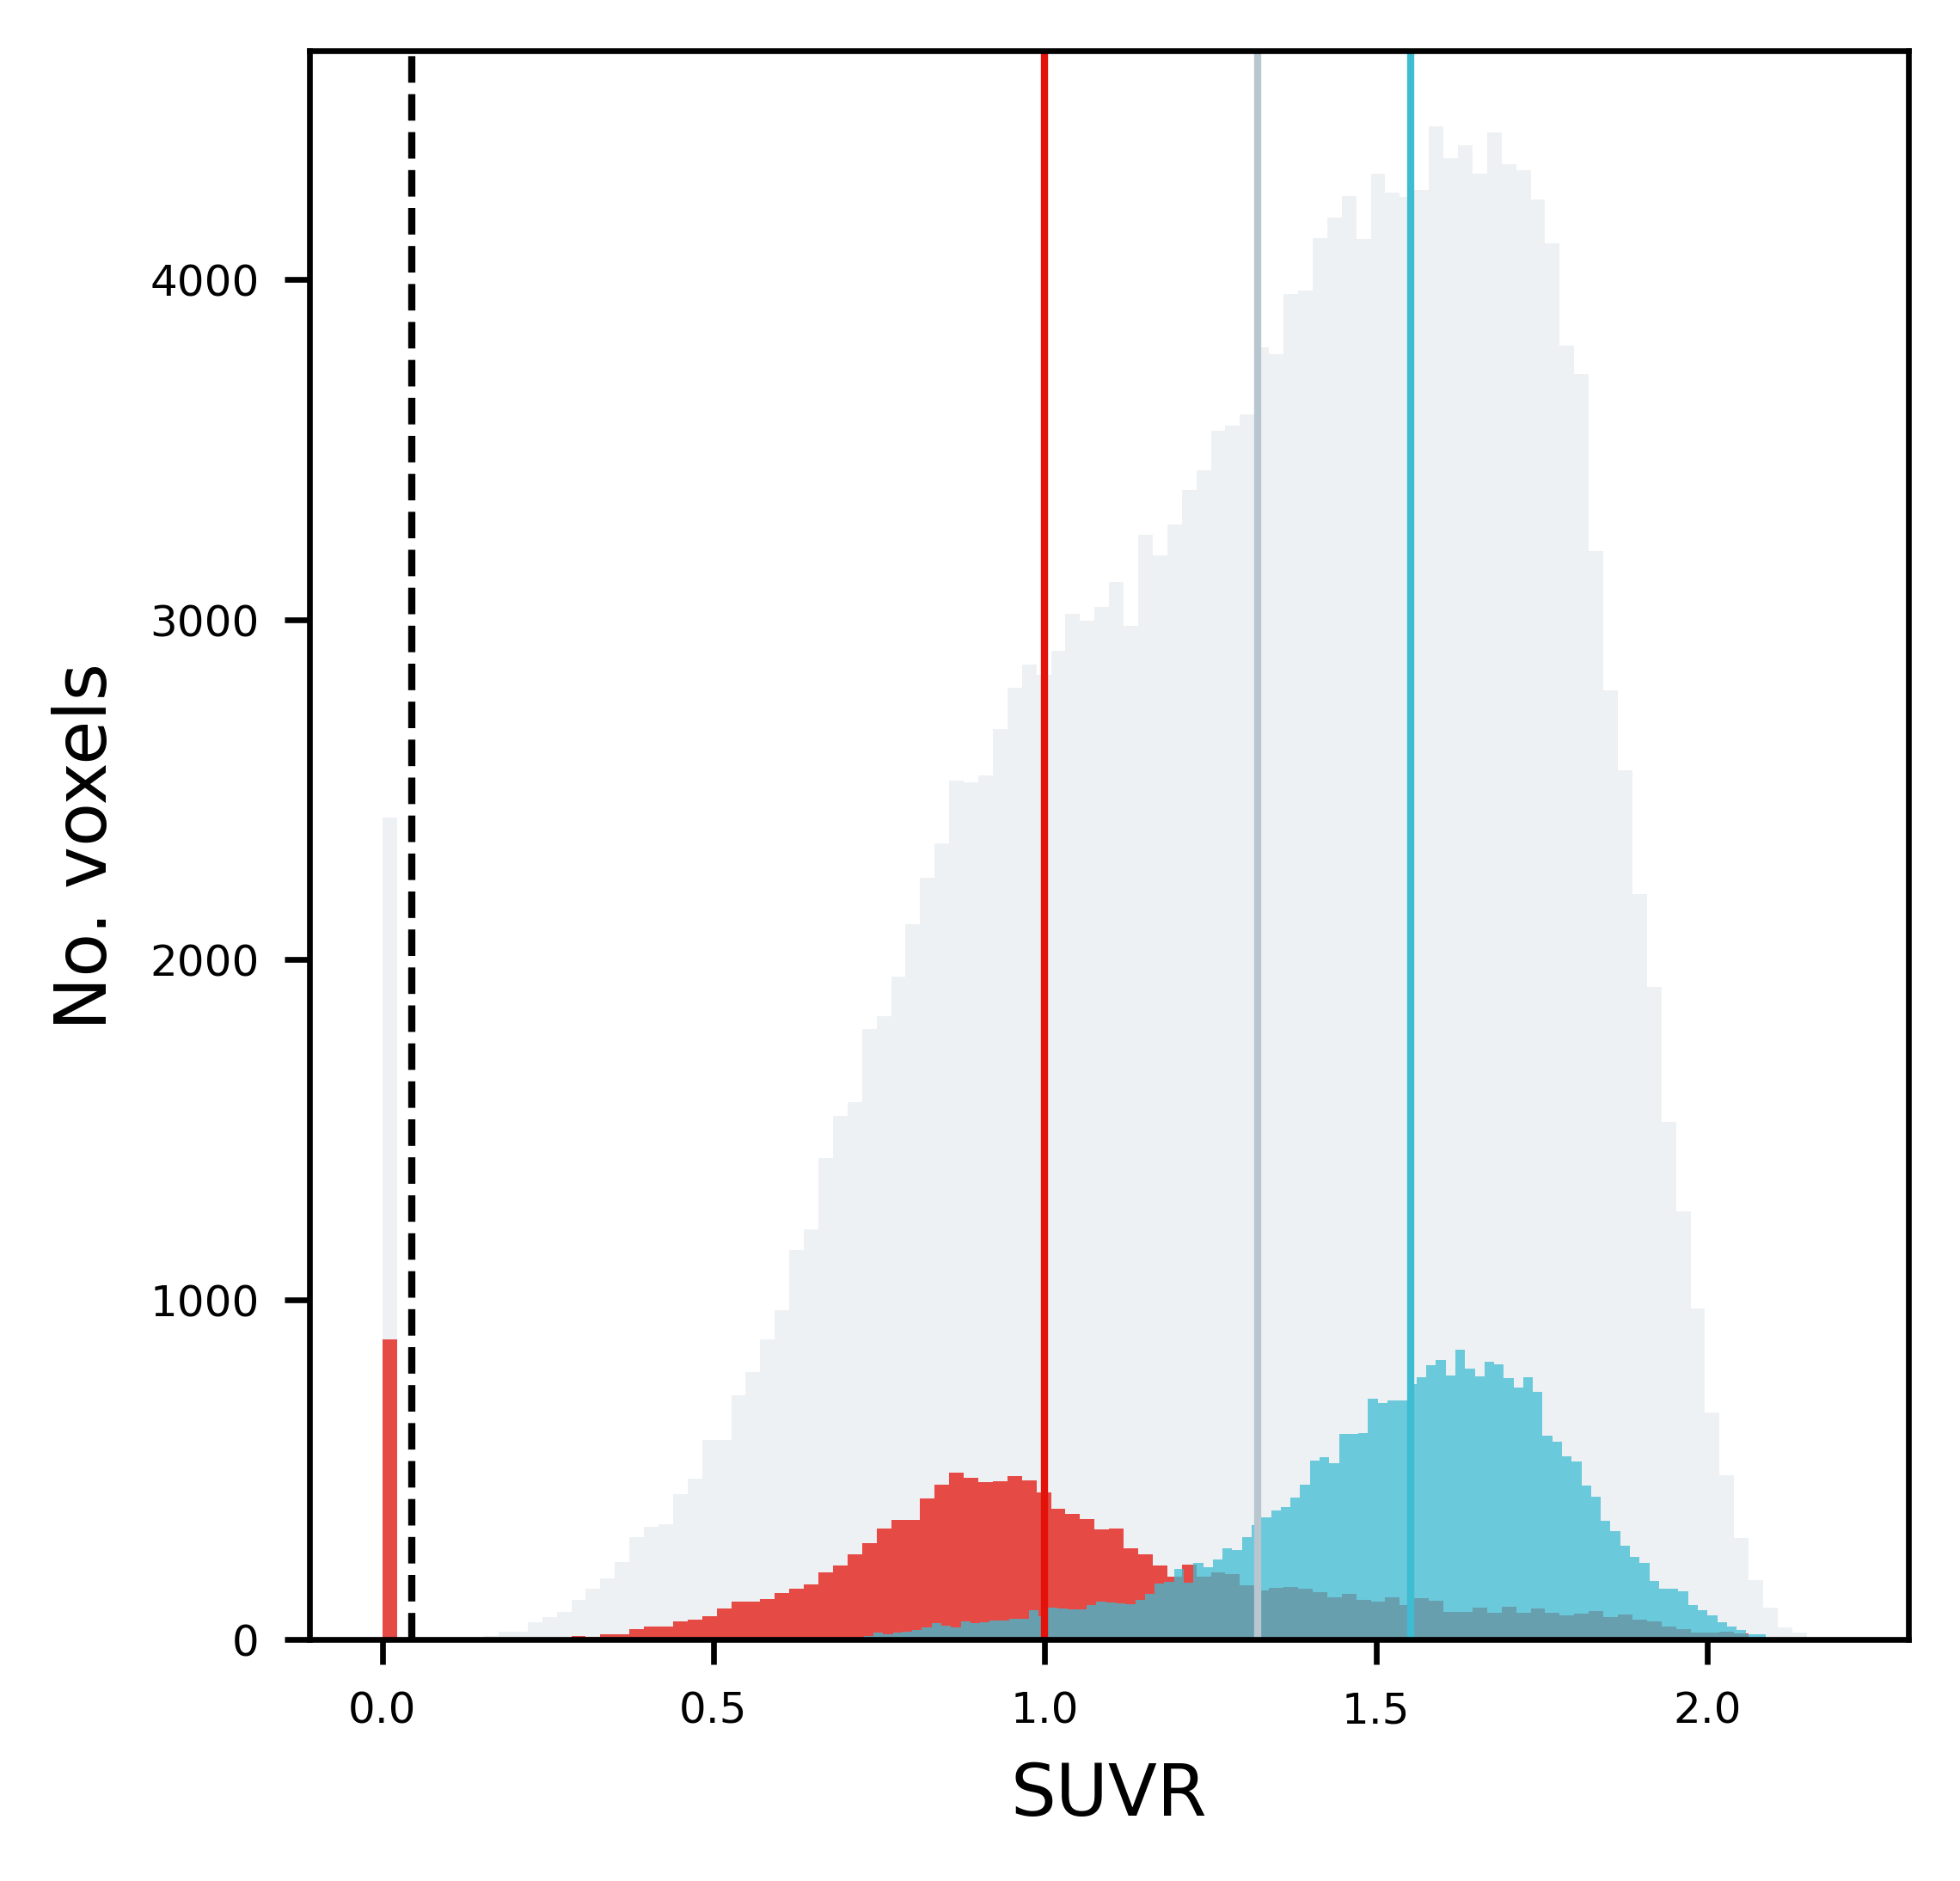

In [112]:
alpha = 0.75
# ------------------

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=600)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
# _ax.hist(suvr[halo_idx].ravel(), bins=100, color='tab:gray', alpha=alpha)
_ax.hist(suvr[wb_idx].ravel(), bins=100, color=co["lgray"], alpha=alpha)
_ax.hist(suvr[rr_idx].ravel(), bins=100, color=co["red"], alpha=alpha)
_ax.hist(suvr[ctx_idx].ravel(), bins=100, color=co["cyan"], alpha=alpha)
_ax.axvline(halo_thresh, color="k", linestyle="--", lw=1)
_ax.axvline(np.mean(suvr[wb_idx]), color=co["gray"], lw=1)
_ax.axvline(np.mean(suvr[rr_idx]), color=co["red"], lw=1)
_ax.axvline(np.mean(suvr[ctx_idx]), color=co["cyan"], lw=1)
# _ax.set_yscale('log')
_ax.tick_params(labelsize=6)
_ax.set_xlabel("SUVR")
_ax.set_ylabel("No. voxels")

wb_size = wb_idx[0].size
rr_size = rr_idx[0].size
ctx_size = ctx_idx[0].size

wb_missing = np.count_nonzero(suvr[wb_idx] < halo_thresh)
rr_missing = np.count_nonzero(suvr[rr_idx] < halo_thresh)
ctx_missing = np.count_nonzero(suvr[ctx_idx] < halo_thresh)

print("Missing voxel cutoff = {:.3f}".format(halo_thresh))
print(
    "Missing {:>6,} ({:.2%}) voxels in the brain".format(
        wb_missing, wb_missing / wb_size
    )
)
print(
    "Missing {:>6,} ({:.2%}) voxels in the ref. region".format(
        rr_missing, rr_missing / rr_size
    )
)
print(
    "Missing {:>6,} ({:.2%}) voxels in the pos-amyloid ROI".format(
        ctx_missing, ctx_missing / ctx_size
    )
)
plt.show()

In [ ]:
# Load every PET SUVR and find halo cutoffs and missing voxels.